<a href="https://colab.research.google.com/github/tolerant-code/Deep-Learning-Project/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import librosa.display
import librosa
from PIL import Image

In [22]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
GTZAN = "/content/drive/MyDrive/Colab Notebooks/GTZAN"

In [24]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

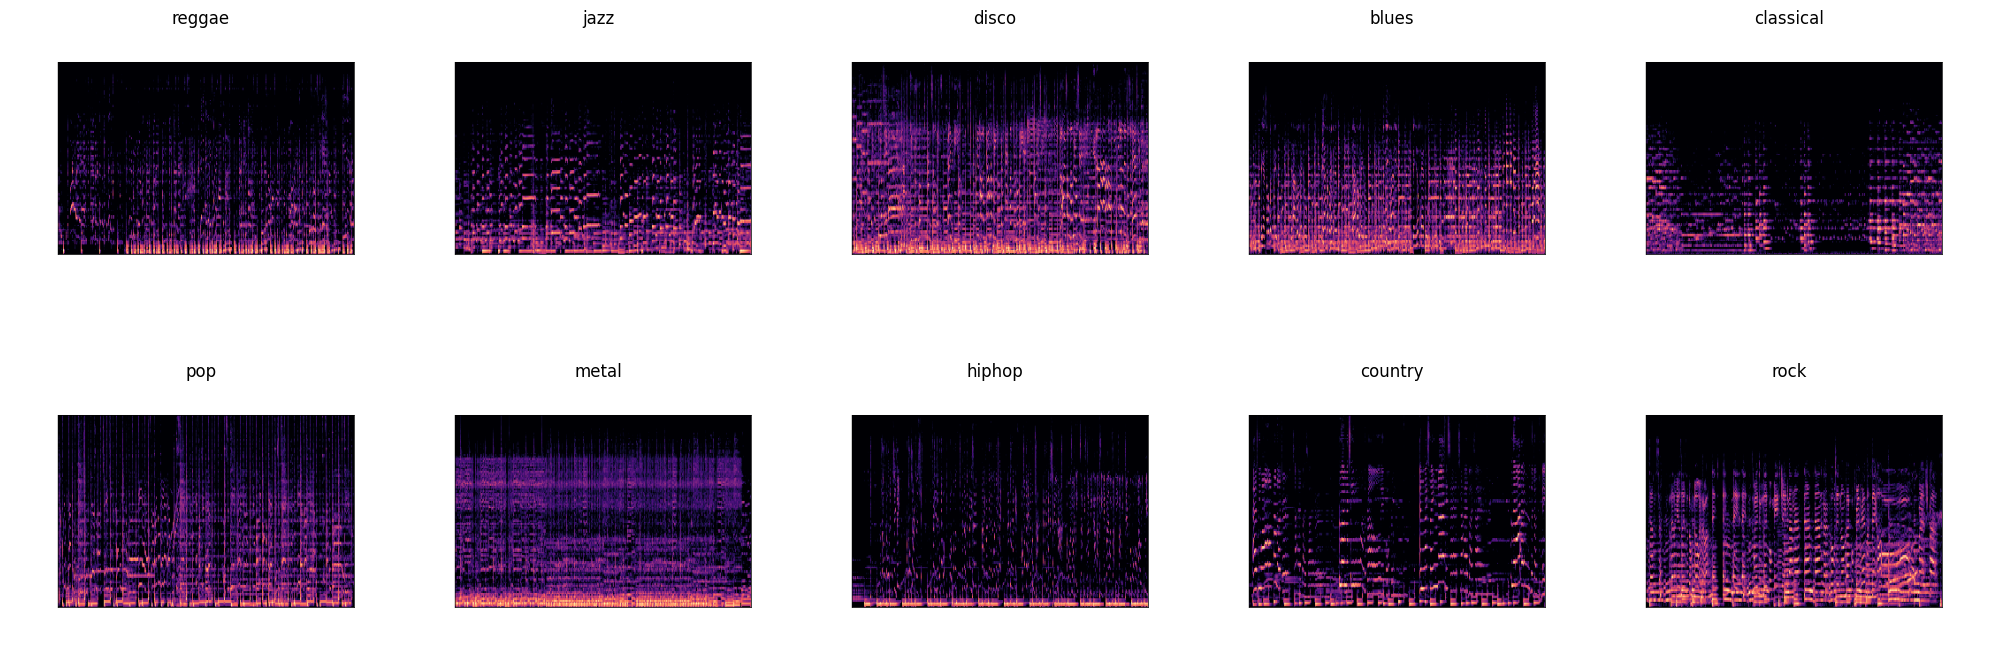

In [31]:
import os
from PIL import Image

genres = os.listdir(GTZAN)
genres = [genre.lower() for genre in genres]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(len(genres)):
    row = i // 5
    col = i % 5
    genre_path = os.path.join(GTZAN, genres[i].lower())
    image_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    image = Image.open(image_path)
    axs[row][col].imshow(image)
    axs[row][col].set_title(genres[i])
    axs[row][col].axis('off')
    
    # Save the image with 300dpi
    save_path = os.path.join(genre_path, f"{genres[i]}.png")
    image.save(save_path, dpi=(300, 300))

plt.tight_layout()
plt.show()

**Extract Image Information**

In [ ]:
# Define empty lists for images and labels
X = []
y = []

# Loop through each genre directory
for genre in genres:
    genre_dir = os.path.join(GTZAN, genre)
    print(genre)
    # Loop through each PNG file in genre directory
    for file_name in os.listdir(genre_dir):
        if file_name.endswith('.png'):
            file_path = os.path.join(genre_dir, file_name)

            # Load PNG image and resize to fixed shape
            image = Image.open(file_path).resize((224, 224))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            # Convert image to numpy array and normalize pixel values
            image = np.array(image) / 255.0

            # Append image and label to X and y lists
            X.append(image)
            y.append(genres.index(genre))

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

reggae
jazz
disco
blues
classical
pop
metal
hiphop
country


## **Build CNN Model**

In [ ]:
# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=len(genres))

# Split dataset into training and validation sets
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(genres), activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

(809, 224, 224, 3)
(100, 224, 224, 3)
(90, 224, 224, 3)
Epoch 1/50
26/26 [==============================] - 14s 109ms/step - loss: 2.4815 - accuracy: 0.1125 - val_loss: 2.2142 - val_accuracy: 0.2000
Epoch 2/50
26/26 [==============================] - 1s 50ms/step - loss: 2.1601 - accuracy: 0.2101 - val_loss: 2.0295 - val_accuracy: 0.2444
Epoch 3/50
26/26 [==============================] - 1s 51ms/step - loss: 1.9778 - accuracy: 0.3127 - val_loss: 1.8269 - val_accuracy: 0.4333
Epoch 4/50
26/26 [==============================] - 1s 50ms/step - loss: 1.8226 - accuracy: 0.3634 - val_loss: 1.7828 - val_accuracy: 0.4444
Epoch 5/50
26/26 [==============================] - 1s 50ms/step - loss: 1.6518 - accuracy: 0.4153 - val_loss: 1.5561 - val_accuracy: 0.5556
Epoch 6/50
26/26 [==============================] - 1s 50ms/step - loss: 1.4614 - accuracy: 0.5006 - val_loss: 1.3715 - val_accuracy: 0.5778
Epoch 7/50
26/26 [==============================] - 1s 50ms/step - loss: 1.3381 - accuracy: 0.49

# **Training and Validation Loss**

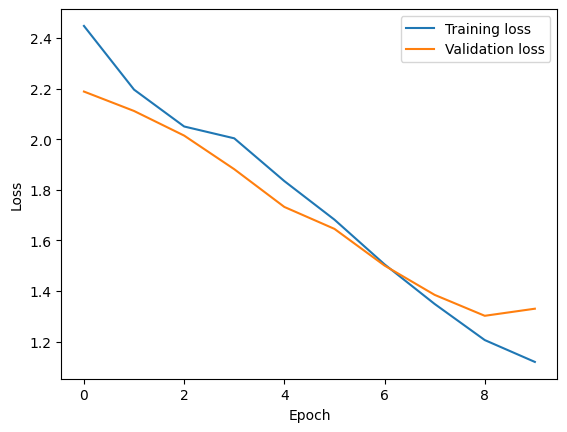

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Training and Validation Accuracy**

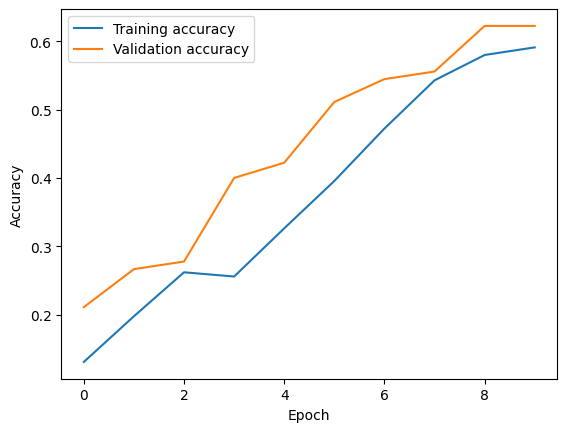

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Confusion Matrix**

4/4 [==============================] - 0s 17ms/step


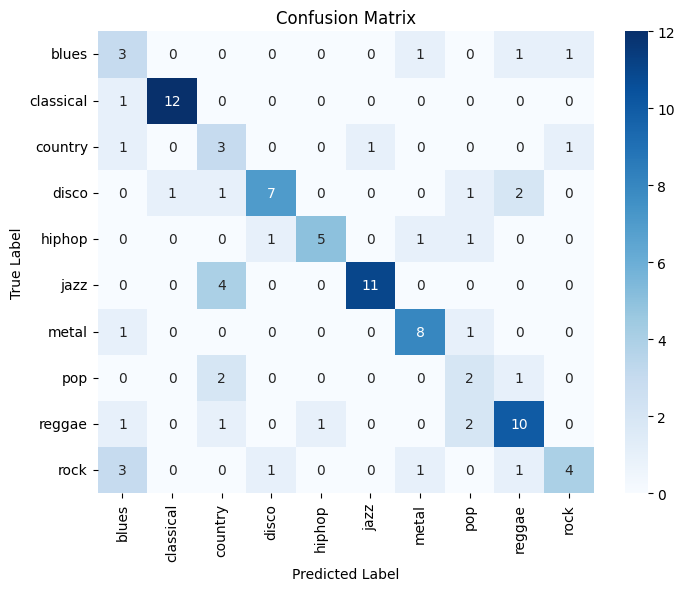

In [ ]:
# Predict probabilities for each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_probs = model.predict(X_test)

# Convert probabilities to class labels
y_preds = np.argmax(y_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

y_probs = model.predict(X_test)

# Convert probabilities to class labels
y_preds = np.argmax(y_probs, axis=1)

# Print classification report
print(classification_report(np.argmax(y_test, axis=1), y_preds, target_names=genres))

4/4 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

       blues       0.30      0.50      0.37         6
   classical       0.92      0.92      0.92        13
     country       0.27      0.50      0.35         6
       disco       0.78      0.58      0.67        12
      hiphop       0.83      0.62      0.71         8
        jazz       0.92      0.73      0.81        15
       metal       0.73      0.80      0.76        10
         pop       0.29      0.40      0.33         5
      reggae       0.67      0.67      0.67        15
        rock       0.67      0.40      0.50        10

    accuracy                           0.65       100
   macro avg       0.64      0.61      0.61       100
weighted avg       0.71      0.65      0.67       100



## **ROC Curve**

4/4 [==============================] - 0s 20ms/step


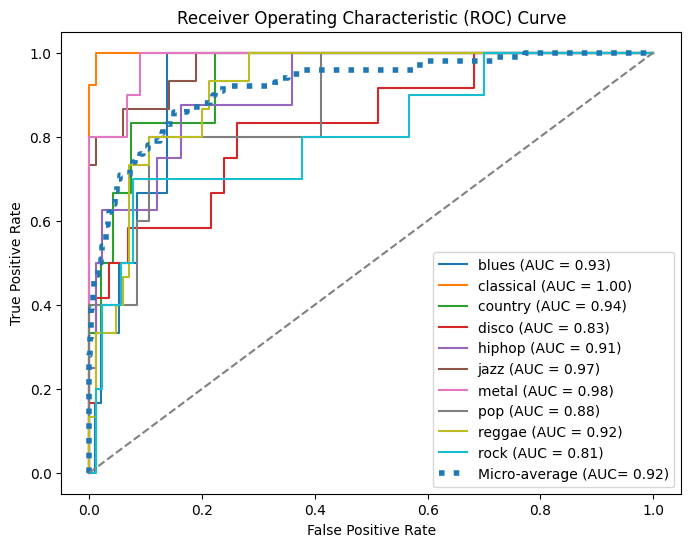

In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
y_probs = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(genres)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(genres)):
    plt.plot(fpr[i], tpr[i], label=f'{genres[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC= {roc_auc_micro:.2f})', linestyle=':', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Set plot title and labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Show plot
plt.show()



---



---

